***
# Research Objective
- Investigate relationship between working population, wages and housing costs in Ann Arbor, MI and San Jose, CA as a case study. This project is a deep dive into three factors of an economy: how many people are working, how much money they make, and how much shelter costs. 
- As a secondary objective, compare sizes of working population between Ann Arbor, MI and San Jose, CA
- Specifically, we would like to explore the following questions
    - Does the average wage earner in Ann Arbor pay more or less for housing in 2020 compared to 2007 ? 
    - How do the earnings and cost of living in Ann Arbor compare to San Jose, CA ?
    - Considering earnings and housing cost, is it 'easier' for a wage earner to buy a houses in AA or SJ?
    - Other questions
        - How do rental prices scale with housing cost? 
     

- Dollar denominated values  (housing costs and wages) will be converted to 2020 dollars to account for inflation. After inflation adjustment, estimated taxes will be subtracted from wages.
***

## Data source #1: State and Area Employment, Hours, and Earnings (https://www.bls.gov/)
- U.S. Bureau of labor statistics is primary source of data used for this project
<br> Use following link to access price and employment statistics https://www.bls.gov/data/#employment
<br> Scoll down to 'Employment, Hours, and Earnings - State and Metro Area' section
<br> Click One-screen data search (linked here https://data.bls.gov/PDQWeb/sm)
<br> Make following selections
   - States: MI and CA
   - Areas: '11460 Ann Arbor, MI'  and '41940 San Jose-sunnyvale-Santa clara, CA'
   - Supersectors: '00 Total Nonfarm', '05 Total Private' and '90 Government'
   - Industries: 'Total Nonfarm', 'Total Private', 'Government'
   - Data types: '01 All employees, in thousands', '02 Average Weekly Hours of Employees',<br>
     '03 Average Hourly Earnings of all employees' 
   - Seasonal adjustment:  check 'not-seasonally adjusted'
   - Download all datasets in resultant page (make sure to adjust date range to 2005-2020) <br>
   <br>
- Also from U.S. Bureau of labor statistics, access price and employment stats for US as a whole
    - Go back to price and employment statistics page https://www.bls.gov/data/#employment
    - Scroll to 'Employment, Hours, and Earnings - National' 
    - Click one-screen data search (linked here https://data.bls.gov/PDQWeb/ce)
    - Select same categories as above, but for entire US

- Also from U.S. Bureau of labor statistics, accessed Consumer Price index data (https://data.bls.gov/PDQWeb/cu)
    - This data will be used for inflation and housing cost calculation
    - For US, Select All-items, all-items less shelter, and shelter only

## Data Source #2: Population data from the Census
Need the total population from the census to compare with working population, we can use reduced date range (2010-2019) for simplicity 
 - https://www.census.gov/data/datasets/time-series/demo/popest/2010s-total-metro-and-micro-statistical-areas.html
 - Dataset used https://www2.census.gov/programs-surveys/popest/tables/2010-2019/metro/totals/cbsa-met-est2019-annres.xlsx

## Data Source #3: Home value and rent index data from Zillow
For a detailed inquiry into housing prices, use the Zillow housing database to estimate of the cost for a home in the US, Ann Arbor, and San Jose.  https://www.zillow.com/research/data/

- Would be cool to compare costs renters face compared with with the homeowning aristocrasy

# Data importing
- Import needed packages 
- Make a helper function to import primary Dept of labor data and combine into dataframes for AA and SJ
- Separate imports of Census and Zillow housing cost data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

### Department of Labor data: numbers of employees in Ann Arbor, San Jose, and broader US
- Data is in thousands employees (i.e. 315.5 = 315,500 persons)
- Total employee count is sum of private and government employees

In [2]:
# Helper function to import the department of labor data, path is file name and col_name is the data name
# number of employees is in thousands
def import_df(path, col_name):
    full_df = pd.read_excel(path,header = 12).set_index(['Year']) #import excelfile, 13'th row is header 
    flat_df = full_df.stack() #flatten it into a time series
    flat_df.name = col_name
    
    return flat_df


US_employees = import_df('all_employees_total_US.xlsx','US_total_employees')
US_private_employees = import_df('all_employees_private_US.xlsx','US_private_employees')
US_gov_employees = import_df('all_employees_gov_US.xlsx','US_gov_employees')

#AA_employees -instead of importing, SUM private and gov employees (NaNs in original data)
AA_private_employees = import_df(
    'all_employees_private_ann_arbor.xlsx','ann_arbor_private_employees')
AA_gov_employees = import_df(
    'all_employees_gov_ann_arbor.xlsx','ann_arbor_gov_employees')

SJ_employees = import_df(
    'all_employees_total_san_jose.xlsx','san_jose_total_employees')
SJ_private_employees = import_df(
    'all_employees_private_san_jose.xlsx','san_jose_private_employees')
SJ_gov_employees = import_df(
    'all_employees_gov_san_jose.xlsx','san_jose_gov_employees')

# Make a list of series to build a dataframe
employee_series = [US_employees,US_private_employees,US_gov_employees,AA_private_employees
                  ,AA_gov_employees,SJ_employees,SJ_private_employees,SJ_gov_employees]

# Transpose to get date as index, then reset the index and rename from 'level 1' to "Month"
employee_numbers = pd.DataFrame(employee_series).T.reset_index()
employee_numbers.rename(columns={'Year':'year','level_1':'month'},inplace=True)

# Adding column for AA total employees = private + government 
employee_numbers['ann_arbor_total_employees'] = employee_numbers[
    'ann_arbor_private_employees'] + employee_numbers['ann_arbor_gov_employees']

# Generate datetime format to use as index, note f string and zip usage
dates = pd.to_datetime([f'{y}-{m}' for y, m in zip(
    employee_numbers.year, employee_numbers.month)], format='%Y-%b')

# Use datetime format as index, sort in ascending order, then drop original year and month cols
# Also, exclude last month (April 2020) due to NaNs in this data
employee_numbers_2 = employee_numbers.set_index(dates).sort_index().drop(columns=['year','month']).iloc[:-1,:]

### CENSUS data: import and compare with employee numbers 
- working_pop1 is key dataframe --> population (in thousands) and raw employment %

In [3]:
#import census data - had to modify due to issue with excel import
pop1 = pd.read_excel('cbsa-met-est2019-annres.xlsx', header=3)
pop2 = pop1.set_index(pop1.iloc[:,0]).iloc[:-5,3:]

pop3 = pop2.loc[['United States','.Ann Arbor, MI Metro Area','.San Jose-Sunnyvale-Santa Clara, CA Metro Area']].reindex().T.reset_index()
pop3.rename(columns={
    'index':'year','.Ann Arbor, MI Metro Area':'AA_pop', '.San Jose-Sunnyvale-Santa Clara, CA Metro Area':'SJ_pop'},inplace=True)

# Convert year to datetime
dates_pop = pd.to_datetime(pop3.year, format='%Y')
pop_4 = pop3.set_index(dates_pop).sort_index().drop(
    columns=['year'])

# Merge with employee numbers dataframe
working_pop = pd.merge(pop_4,employee_numbers_2, how='left', left_index=True, right_index=True)

# Adusting populations from census to 1000's of people
working_pop['US_population'] = working_pop['United States']/1000
working_pop['ann_arbor_population'] = working_pop['AA_pop']/1000
working_pop['san_jose_population'] = working_pop['SJ_pop']/1000

# Calculating employment_%
working_pop['US_employment_%'] = 100*working_pop['US_total_employees']/working_pop['US_population']
working_pop['ann_arbor_employment_%'] = 100*working_pop['ann_arbor_total_employees']/working_pop['ann_arbor_population']
working_pop['san_jose_employment_%'] = 100*working_pop['san_jose_total_employees']/working_pop['san_jose_population']

# Columns to generate figure comparing population and employment %
working_pop1 = working_pop[[
    'US_population','US_employment_%','ann_arbor_population','ann_arbor_employment_%',
    'san_jose_population','san_jose_employment_%']]

In [131]:
#Check
working_pop1;

### Department of Labor data: Income 
- Data is for employees in private sector only
- Government job data was not included in department of labor datasets 

In [5]:
#getting hourly earnings and weekly hours for US AA and SJ
US_hours = import_df(
    'weekly_hours_private_US.xlsx','US_weekly_hours')
AA_hours = import_df(
    'weekly_hours_private_ann_arbor.xlsx','AA_weekly_hours')
SJ_hours = import_df(
    'weekly_hours_private_san_jose.xlsx','SJ_weekly_hours')
US_hourly_wage = import_df(
    'hourly_earnings_avg_private_US.xlsx','US_hourly_wage')
AA_hourly_wage = import_df(
    'hourly_earnings_avg_private_ann_arbor.xlsx','AA_hourly_wage')
SJ_hourly_wage = import_df(
    'hourly_earnings_avg_private_san_jose.xlsx','SJ_hourly_wage')

#making a list of all these to build a dataframe
wage_series = [US_hours,US_hourly_wage,AA_hours,AA_hourly_wage,
                  SJ_hours,SJ_hourly_wage]

# Transpose to get date as index, then reset the index and rename month index from 'level 1' to "Month"
wages = pd.DataFrame(wage_series).T.reset_index()
wages.rename(columns={'Year':'year','level_1':'month'},inplace=True)

# datetime format to use as index, note fancy f string and zip usage
dates_wage = pd.to_datetime([f'{y}-{m}' for y, m in zip(
    wages.year, wages.month)], format='%Y-%b')

# Use formatted datetime as index, then sorting in ascending order and dropping original year and month cols
# Excluding Apr 2020 due to align with employee_numbers data (and avoids Covid bull-crap) 
wages_2 = wages.set_index(dates_wage).sort_index().drop(
    columns=['year','month']).iloc[:-1,:]


# Hourly earnings and weekly hours are fine, but we want monthly wages to compare the cost of rent per month
# Loop generate monthly wage columns, append to dict then make it a dataframe  
monthly_wage = {} #empty dict to append to
cols = wages_2.columns #column names 
for i in range(0,6,2): #looping by 2 (0,2,4)
    monthly = (wages_2[cols[i]]*wages_2[cols[i+1]]*52.143)/12 # * 52.143 weeks per year / 12 months per year
    monthly_wage.update({cols[i][:2]+'_monthly_wage':monthly}) #appending to dict

m_wage_df = pd.DataFrame(monthly_wage) #make it a dataframe

### Housing costs: Load zillow data
- Zillow home value gives value of home within 20-60% quartile in dollar denomination
     - A simple calculation will be used to derive monthly housing 'cost' from home value index (an effective rent metric)
     - Assume entire value will be paid over a 30 year mortgage with a 10% down payment
         - Down payment cost is also distributed over the 30 yrs to account for the cost, but is not subject to interest
         - Historical mortage rates indicate ~4-6% interest from 2006-2020 https://www.valuepenguin.com/mortgages/historical-mortgage-rates
         - We will use 5% effective interest on homes to account for property taxes  
- Zillow rent index is already dollar denominated and represents smoothed 20-60% quartile range of per month rental costs       

In [6]:
# Getting housing value and rent index 
zillow_house = pd.read_csv('Metro_Zhvi_AllHomes.csv') 
zillow_rent = pd.read_csv('Metro_Zri_AllHomesPlusMultifamily.csv', encoding = "ISO-8859-1") 

# Reformatting house dataframe only keep data from 2006
zillow_house2 = zillow_house.drop(columns = ['RegionID','SizeRank','RegionType','StateName']).set_index('RegionName').loc[[
    'United States','San Jose, CA','Ann Arbor, MI']].T.iloc[120:,:]
zillow_house2.rename(columns={'San Jose, CA':'SJ_home_value','Ann Arbor, MI':'AA_home_value','United States':"US_home_value"},inplace=True)

# Reformat rent index dataframe
zillow_rent2 = zillow_rent.drop(columns = ['RegionID','SizeRank']).set_index('RegionName').loc[[
    'United States','San Jose, CA','Ann Arbor, MI']].T
zillow_rent2.rename(columns={'San Jose, CA':'SJ_rent','Ann Arbor, MI':'AA_rent','United States':"US_rent"},inplace=True)

#Re-formatting the date index for house, note that to_period().to_timestamp() changes timestamp from end of month to beginning
house_dates = pd.to_datetime(zillow_house2.index, format='%Y-%m').to_period().to_timestamp()
zillow_house2 = zillow_house2.set_index(house_dates)

#re-formatting the date index for rent
rent_dates = pd.to_datetime(zillow_rent2.index, format='%Y-%m')
zillow_rent2 = zillow_rent2.set_index(rent_dates) #dates formateed to align with zillow_house2

# Calculate Owner cost per month, assuming 30 yr 5% apr mortgage with 10% down payment (down payment cost is distributed over mortgage)
# note that np.pmt gives a monthly payment as a negative (-), so the down payment cost is subtracted then the total changed to positive (+)
zillow_house2['US_owner_cost'] = -(np.pmt(0.05/12, 30*12, zillow_house2['US_home_value']*0.9)-(0.1*zillow_house2['US_home_value'])/(30*12))
zillow_house2['SJ_owner_cost'] = -(np.pmt(0.05/12, 30*12, zillow_house2['SJ_home_value']*0.9)-(0.1*zillow_house2['SJ_home_value'])/(30*12))
zillow_house2['AA_owner_cost'] = -(np.pmt(0.05/12, 30*12, zillow_house2['AA_home_value']*0.9)-(0.1*zillow_house2['AA_home_value'])/(30*12))

# Merge renting data with owner data
housing = pd.merge(zillow_house2, zillow_rent2, left_index=True, right_index=True, how='outer')

### Inflation adjustment: Load CPI data
- Purchasing power is decreased over time due to inflation, we need to adjust <2020 dollars to equivalent 2020 dollars 
- Formula for inflation (dollar amount in one year expressed as dollar amount in another year) <br>
(year_2_value) = (year_1_value)*cpi_2/cpi_1 <br>
 - Take a value from an earlier year (year_1_value), multiply it by cpi_2020/cpi_y1 to get the value in 2020 dollars
 - For cpi_2020, take 1st quarter mean (Jan-Feb-March) 

In [7]:
# Load 'em and stack 'em
# import CPI data, drop last two cols (named half1 and half2) 
cpi_rough = pd.read_excel(
    'CPI_all_items_US.xlsx',header = 11).iloc[:,:-2].set_index(['Year'])
cpi_rough_less_shelter = pd.read_excel(
    'CPI_all_items_less_shelter_US.xlsx',header = 11).iloc[:,:-2].set_index(['Year'])
cpi_rough_shelter = pd.read_excel(
    'CPI_shelter_US.xlsx',header = 11).iloc[:,:-2].set_index(['Year'])

#Stack 'em
cpi = cpi_rough.stack() #flatten it into a time series
cpi.name = 'CPI_all_items'

cpi_less_shelter = cpi_rough_less_shelter.stack() #flatten it into a time series
cpi_less_shelter.name = 'CPI_less_shelter'

cpi_shelter = cpi_rough_shelter.stack()
cpi_shelter.name = "CPI_shelter"

#CPI data frame, excluding april
cpi_all = pd.DataFrame([cpi, cpi_less_shelter, cpi_shelter]).T.iloc[:-1,:].reset_index()
cpi_all.rename(columns={'Year':'year','level_1':'month'},inplace=True)

#format index to datetime same as before
dates_cpi = pd.to_datetime([f'{y}-{m}' for y, m in zip(
    cpi_all.year, cpi_all.month)], format='%Y-%b')

#main dataframe to do calulations and data analysis
cpi_all_2 = cpi_all.set_index(dates_cpi).sort_index().drop(
    columns=['year','month'])

# As a reference point for inflation calculation, we need CPI for 2020
# Calculate mean CPI for 2020 for all items, all items less shelter, and shelter 
mean_cpi_less_shelter = cpi_all_2.iloc[-3:,:].mean().loc['CPI_less_shelter']
mean_cpi_all = cpi_all_2.iloc[-3:,:].mean().loc['CPI_all_items']
mean_cpi_shelter = cpi_all_2.iloc[-3:,:].mean().loc['CPI_shelter']

# Finally, we have the CPI ratios we need to adjust values to 2020 dollars 
cpi_ratios_all = mean_cpi_all / cpi_all_2['CPI_all_items']
cpi_ratios_all.name = 'CPI_ratio_all'

cpi_ratios_less_shelter = mean_cpi_less_shelter / cpi_all_2['CPI_less_shelter']
cpi_ratios_less_shelter.name = 'CPI_ratio_less_shelter'

### Inflation adjustment: Calculation
- Apply CPI ratios (less shelter) to wages for conversion to 2020 dollars --> df name 'm_wage_df'
- Apply CPI ratios to home values for same reason --> df name 'housing_adj'
    - Using CPI less shelter to caluclate the base inflation without influence from housing
    - less shelter inflation adjusted Housing cost is isolated from housing effect on CPI 

In [8]:
# Adjust wages for inflation
m_wage_df['AA_monthly_wage_adjusted'] = m_wage_df['AA_monthly_wage'] * cpi_ratios_less_shelter
m_wage_df['SJ_monthly_wage_adjusted'] = m_wage_df['SJ_monthly_wage'] * cpi_ratios_less_shelter
m_wage_df['US_monthly_wage_adjusted'] = m_wage_df['US_monthly_wage'] * cpi_ratios_less_shelter


# Adjusting housing costs for inflation (using cpi_ratios less shelter from >2006)
housing_adj = housing.copy()
for col in housing.columns:
    housing_adj[f'{col}_adj'] = housing[f'{col}']*cpi_ratios_less_shelter[12:]

### Tax rate adjustment 
- Taxes should be accounted for in the analysis. We want to study how much a person's take home pay gets them
- US has a progressive tax rate - the more income, the higher the effective tax rate
- We approximate the tax burden by only considering Federal taxes at the same rate as 2020, in 2020 dollars https://www.nerdwallet.com/blog/taxes/federal-income-tax-brackets/
    - For simplicity, we assume each individual is filling as single and takes the standard deduction
    - In reality, many will file married and have itemized deductions (children,etc) so this calculation will overestimate Federal taxes
    - On the other hand, we are not accounting for state income taxes which will underestimate the tax burden, so these factors will cancel out to an extent
    - Since this adjustment is only to get the first order effect of progressive tax, this approximation should be allowed 

In [9]:
def tax(income):
    
    standard_deduction = 12400 #2020 standard deduction
    adj_income = income - standard_deduction #adjusted gross income
    
    if (adj_income < 9876): #first tax bracket taxed at 10%
        tax = adj_income*0.1
    elif 9875 < adj_income < 40126: #second bracket taxed at 12%
        tax = 987.5 + (adj_income-9875)*0.12
    elif 40125 < adj_income < 85526: #third bracket taxed at 22%
        tax = 987.5 + 3630 + (adj_income - 40125)*0.22
    else: # fourth bracket taxed at 24%
        tax = 987.5 + 3630 + 9988 + (adj_income - 85525)*0.24 
        
    taxed_income = income - tax
    return taxed_income

In [10]:
#yearly income 
m_wage_df['US_income'] = m_wage_df['US_monthly_wage_adjusted']*12
m_wage_df['AA_income'] = m_wage_df['AA_monthly_wage_adjusted']*12
m_wage_df['SJ_income'] = m_wage_df['SJ_monthly_wage_adjusted']*12

# Np has error when trying to evaluate series as boolean (due to conditional statements in tax funtion)
# As workaround, use apply then divide by 12 to get monthly income after taxes
m_wage_df['US_taxed'] = m_wage_df.apply(lambda row: tax(row['US_income'])/12,axis =1)
m_wage_df['AA_taxed'] = m_wage_df.apply(lambda row: tax(row['AA_income'])/12,axis =1)
m_wage_df['SJ_taxed'] = m_wage_df.apply(lambda row: tax(row['SJ_income'])/12,axis =1)

## Prepare for analysis: Combine and describe key dataframes
- Incomes and housing values adjusted for inflation and taxes, and working populations are core datasets
- If needed, can repeat analysis without inflation adjustments

In [132]:
# Key data component - housing values, owner cost and rent in 2020 dollars
# **_home_value_adj is home value in 2020 dollars
# **_owner_cost_adj is calculated monthly cost of ownership in 2020 dollars, assuming 30yr/5% apr/10% down mortgage
# **_rent_adj is rent index in 2020 dollars 
housing_adj.iloc[:,-9:].head();

In [133]:
# Key data component - monthly income in 2020 dollars adjusted for income tax
m_wage_df.iloc[:,:].head();

In [134]:
# Key data component - working population
working_pop1;

In [14]:
adjusted_stuff = pd.merge(housing_adj.iloc[:,-9:], m_wage_df.iloc[:,-3:], left_index=True, right_index=True, how='outer')

In [135]:
adjusted_stuff.tail();

# Exploratory data analysis

First look at the monthly wages for the different areas. Most striking feature is that San Jose monthly income is nearly double the income of Ann Arbor. From a raw income perspective, show me the way to San Jose! It will be interesting to see how the two areas compare after factoring in the cost of living and Uncle Sam's share of this wealth. Looking at Ann Arbor, we can see that it is roughly in line with the US average, but has an interesting 'boom and bust' feature from 2007 to 2011. Towards the end of 2007, Ann Arbor exhibits income well above the US mean, but, by 2011, the income has dropped precipitously to a multi-year low in contrast to mean US income. 2019 to Mar 2020 seems to be showing a similar trend, we can speculate that the next year or two will be rough for our Ann Arbor friends.

In [16]:
#Note rcParams is very usefule for setting default seetings ahead of plotting
#plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 14})
#m_wage_df.iloc[:,:3].plot()

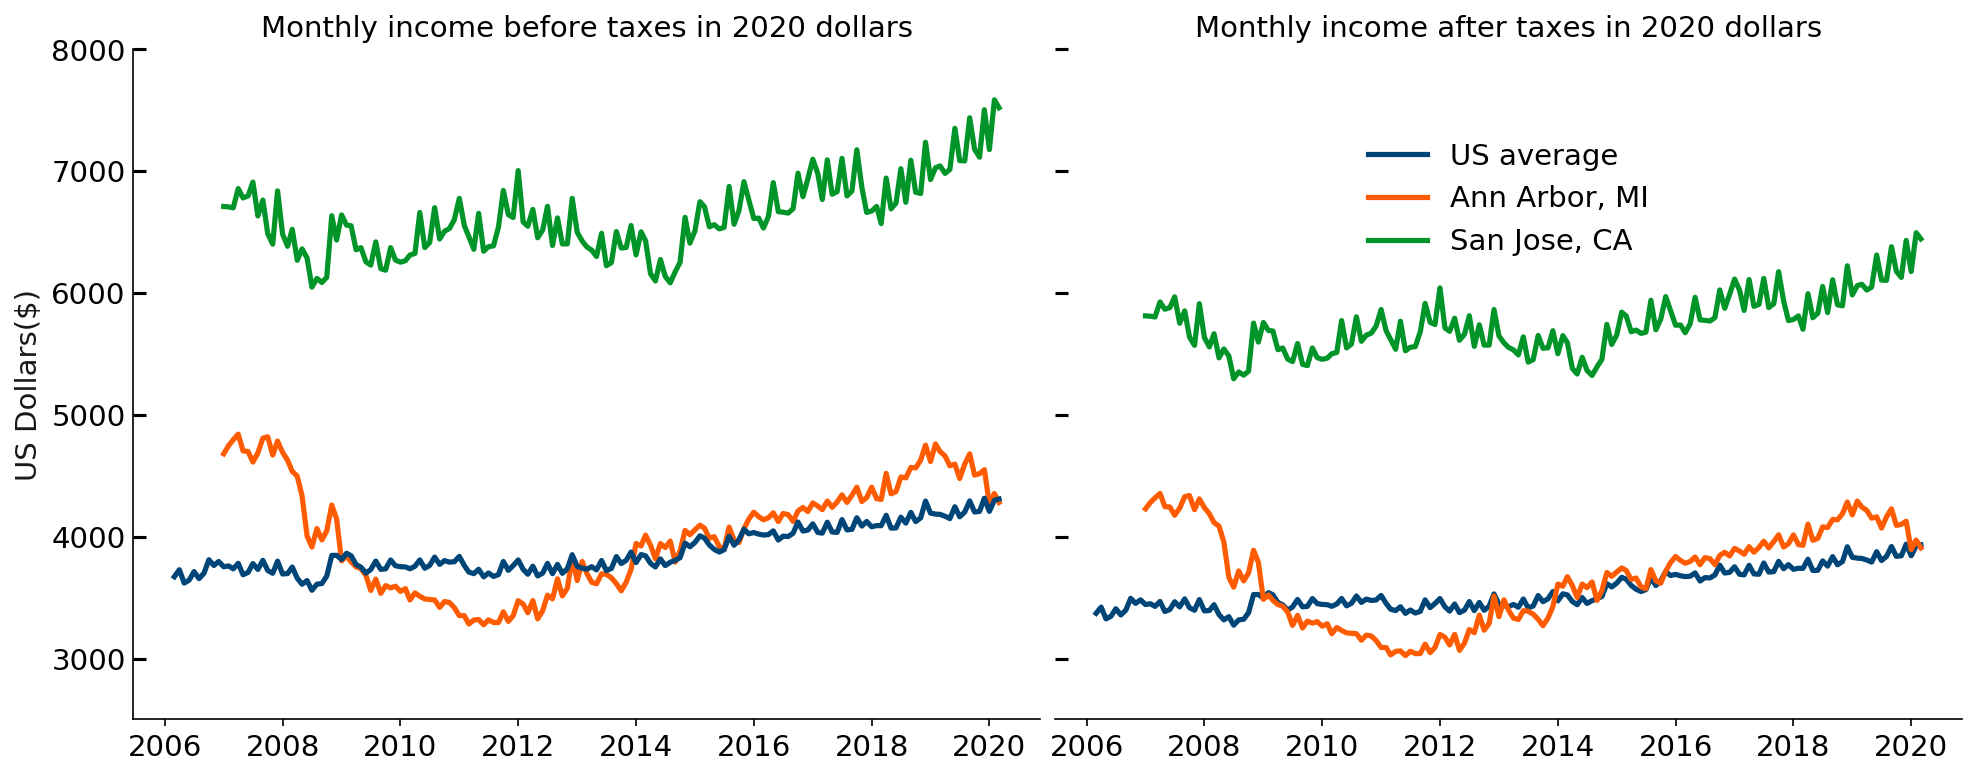

In [18]:
fig = plt.figure(figsize=(13,5))

ax1, ax2 = fig.subplots(1, 2, sharey=True)

ax1.set_prop_cycle(color=['xkcd:bright orange', 'xkcd:irish green', 'xkcd:prussian blue']) #label=['Ann Arbor, MI','San Jose, CA','US average'] #specify colors to plot
ax1.plot(m_wage_df.iloc[:,3:6], '-', lw = 2.5)
ax1.set_title('Monthly income before taxes in 2020 dollars',fontsize='medium')

ax2.set_prop_cycle(color=['xkcd:prussian blue','xkcd:bright orange','xkcd:irish green']) #specify colors to plot
ax2.plot(m_wage_df.iloc[:,-3:], '-', lw=2.5)
ax2.set_title('Monthly income after taxes in 2020 dollars',fontsize='medium')

ax1.tick_params(axis='y',direction = 'in',length=6, width=1.5)
ax1.tick_params(axis='both',labelsize='medium')
ax1.set_ylabel('US Dollars($)', alpha=0.9,fontsize='medium')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.tick_params(axis='y',direction = 'in',length=6, width=1.5)
ax2.tick_params(axis='both',labelsize='medium')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax1.set(ylim=(2500, 8000))
ax2.set(ylim=(2500, 8000))

leg = plt.legend(['US average','Ann Arbor, MI','San Jose, CA'],fontsize='medium', frameon=False, loc = "upper center", bbox_to_anchor = (0.5,0.9))
 

fig.tight_layout(pad=0.05)
plt.savefig('assingment_4_figure_income_before-and-after-taxes.png', dpi = 300)

***
#### Working population comparison
- Want to see the proportion of an area's population that is employed
- Of course, children, students, seniors, and the disabled are not working
- Interestingly, the raw employment for the U.S. is <50% 
- Comparatively, Ann Arbor and SJ have higher proportion of their populations in the workforce
- We also notice that the raw employment in San Jose is increasing at a faster rate than the US or Ann Arbor, potentially reflecting a significant demographic change (for example, maybe tech workers with no children are displacing seniors)
- It would be interesting to dive into this and partition the components of the non-working population, but that is beyond the scope of this study
- Another interesting feature is that Ann Arbor and San Jose's overall population growth (year-over-year) has plummeted in recent years. In fact, both metro areas have experienced negative population growth in 2019! For San Jose, we can speculate that the high cost of housing is pricing people out, but it is not clear why Ann Arbor has experieced a similar outflow.

In [20]:
# add in percent growth of population column
def percent_growth(pop):
    growth = [100*(pop[1]-pop[0])/(2*pop[0]-pop[1])] #extrapolate first point
    for i in range(1,len(pop)):
        p_growth = 100*(pop[i] - pop[i-1]) / pop[i-1]
        growth.append(p_growth)
    return growth

In [21]:
working_pop2 = working_pop1.copy()
working_pop2['US_growth'] = percent_growth(working_pop1['US_population'])
working_pop2['ann_arbor_growth'] = percent_growth(working_pop1['ann_arbor_population'])
working_pop2['san_jose_growth'] = percent_growth(working_pop1['san_jose_population'])

In [126]:
working_pop2;

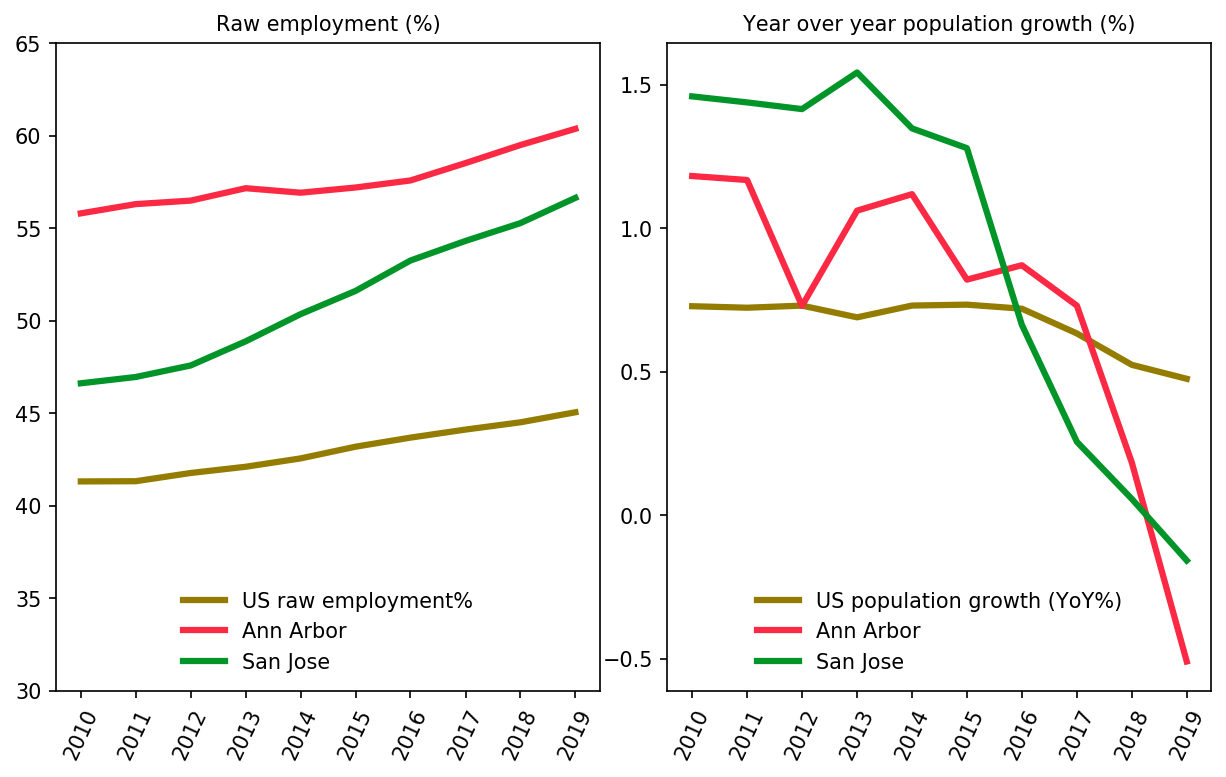

In [89]:
fig1 = plt.figure(figsize=(8,5))

ax_1, ax_2 = fig1.subplots(1, 2, sharey=False)


ax_1.set_prop_cycle(color=['xkcd:baby poop','xkcd:strawberry','xkcd:irish green']) #specify colors to plot
ax_1.plot(working_pop1[['US_employment_%','ann_arbor_employment_%','san_jose_employment_%']],lw = 3)
ax_1.set(ylim=(30, 65))
ax_1.set_title("Raw employment (%)",fontsize='small')
ax_1.tick_params(axis='both', labelsize = 'small')
ax_1.tick_params(axis='x', labelrotation = 65)
ax_1.legend(['US raw employment%','Ann Arbor','San Jose'],fontsize='small',frameon=False,loc="lower center") 

ax_2.set_prop_cycle(color=['xkcd:baby poop','xkcd:strawberry','xkcd:irish green'])
ax_2.plot(working_pop2[['US_growth','ann_arbor_growth','san_jose_growth']], '-', lw = 3)
ax_2.tick_params(axis='both', labelsize = 'small')
ax_2.tick_params(axis='x', labelrotation = 65)
ax_2.set_title("Year over year population growth (%)",fontsize='small')
ax_2.legend(['US population growth (YoY%)','Ann Arbor','San Jose'], fontsize='small', frameon=False, loc="lower center") 


fig1.tight_layout(pad=0.05)
plt.savefig('assingment_4_figure_employment_population_growth.png', dpi = 300)

***
### Inflation visualizaion with CPI index
Look at Consumer Price Index (CPI) for US urban areas. Fascinating how decoupled shelter costs and all other items are. Shelter looks to be exhibiting near exponential growth from 2010-2015 and is steadily rising faster than all other items. We can see the marked effect on inflation just from shelter costs. Personally, I find this trend very disturbing for our society, as more people will be unable to afford shelter and might end up on the streets or turning to crime to make ends meet. Perhaps this demonstrates a transfer of wealth from non-property owners to the property owning class.    

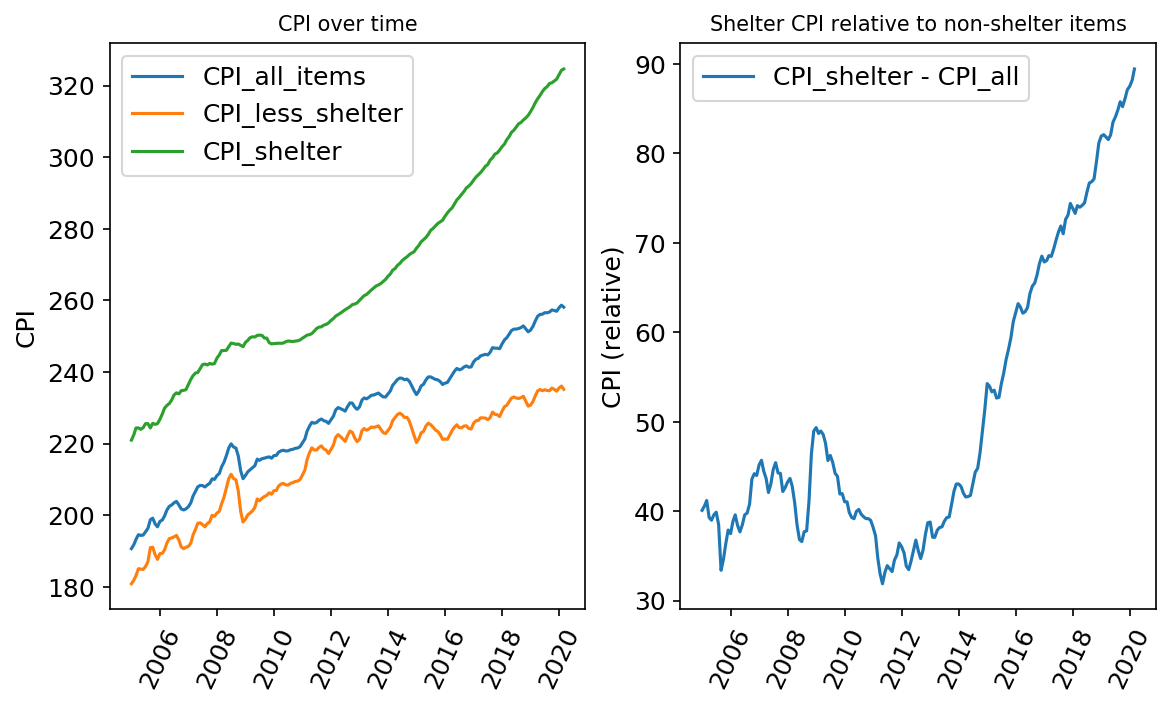

In [125]:
shelter_subtracted = cpi_all_2['CPI_shelter'] - cpi_all_2['CPI_less_shelter']

fig2 = plt.figure(figsize=(9,5))
ax_1, ax_s = fig2.subplots(1, 2, sharey=False)

ax_1.plot(cpi_all_2)
ax_1.legend(cpi_all_2.columns)
ax_1.set_ylabel("CPI")
ax_1.set_title("CPI over time",fontsize='smaller')
ax_1.tick_params(axis='x', labelrotation = 65)

ax_s.plot(shelter_subtracted)
ax_s.set_title("Shelter CPI relative to non-shelter items",fontsize='smaller')
ax_s.set_ylabel("CPI (relative)")
ax_s.legend(['CPI_shelter - CPI_all'])
ax_s.tick_params(axis='x', labelrotation = 65)

Subtracting out all items less shelter from shelter CPI, we see the relative increase in shelter costs compared to everything else. <br>
Shelter cost index has outpaced all other items substantially during the past decade!

***
## Primary data analysis
- Want to visualize trends between housing and income

In [90]:
#Check col names
adjusted_stuff.columns;

In [27]:
# Catergories for comparison
home_values = adjusted_stuff[['US_home_value_adj', 'SJ_home_value_adj', 'AA_home_value_adj']]/1000 #values in 1000's of 2020 dollars
owner_costs = adjusted_stuff[['US_owner_cost_adj', 'SJ_owner_cost_adj', 'AA_owner_cost_adj']]
rent = adjusted_stuff[['US_rent_adj', 'SJ_rent_adj', 'AA_rent_adj']]
income = adjusted_stuff[['US_taxed', 'SJ_taxed','AA_taxed']]

In [28]:
# Smaller font size needed for next plots
plt.rcParams.update({'font.size': 12})

### Look at cost of home ownership compared to rent index
- Ann Arbor closely tracks broader US in inflation adjusted cost of home ownership (COHO) and rent
- COHO is rising for all three regions (and rising aggressively for San Jose), rent index is steady for US and Ann Arbor, and rising for San Jose, but slower than COHO
- In both Ann Arbor and US, it is more expensive to rent than to own. We would expect that this fact leads to higher proportion of home ownership vs renters
    - Of course, there is opportunity costs in home ownership tied into the down payment, but very likely this cost is offset by the building equity in the home vs rent
    - However, in recent months the cost of rent in Ann Arbor is trending towards being below the cost of ownership, it would be interesting to follow this closely and to itentify demographic causes 
- San Jose stands out compared to US and Ann Arbor. Specifically, the cost of rent is much lower than the cost of ownership
    - We expect that relatively more people will rent in San Jose with time. In 2011-2012, the difference was smaller, meaning it was a good time to become a homeowner. Notwithstanding future market performance, renting is relatively more attractive in recent years 
    - As a renter in the San Jose market, this analysis has decreased my fear of missing out on home ownership, due to the opportunity costs of prohibitively high COHO. 
    - An interesting follow up study could investigate the return on equity of a homeowner vs a renter who invests the money saved per month (compared to COHO) in the S&P 500
        - My back of the envelope calculation indicates that for capital appreciation, renting and investing would have returned more that 2x than building equity in a home in SJ (even with the housing market appreciation)

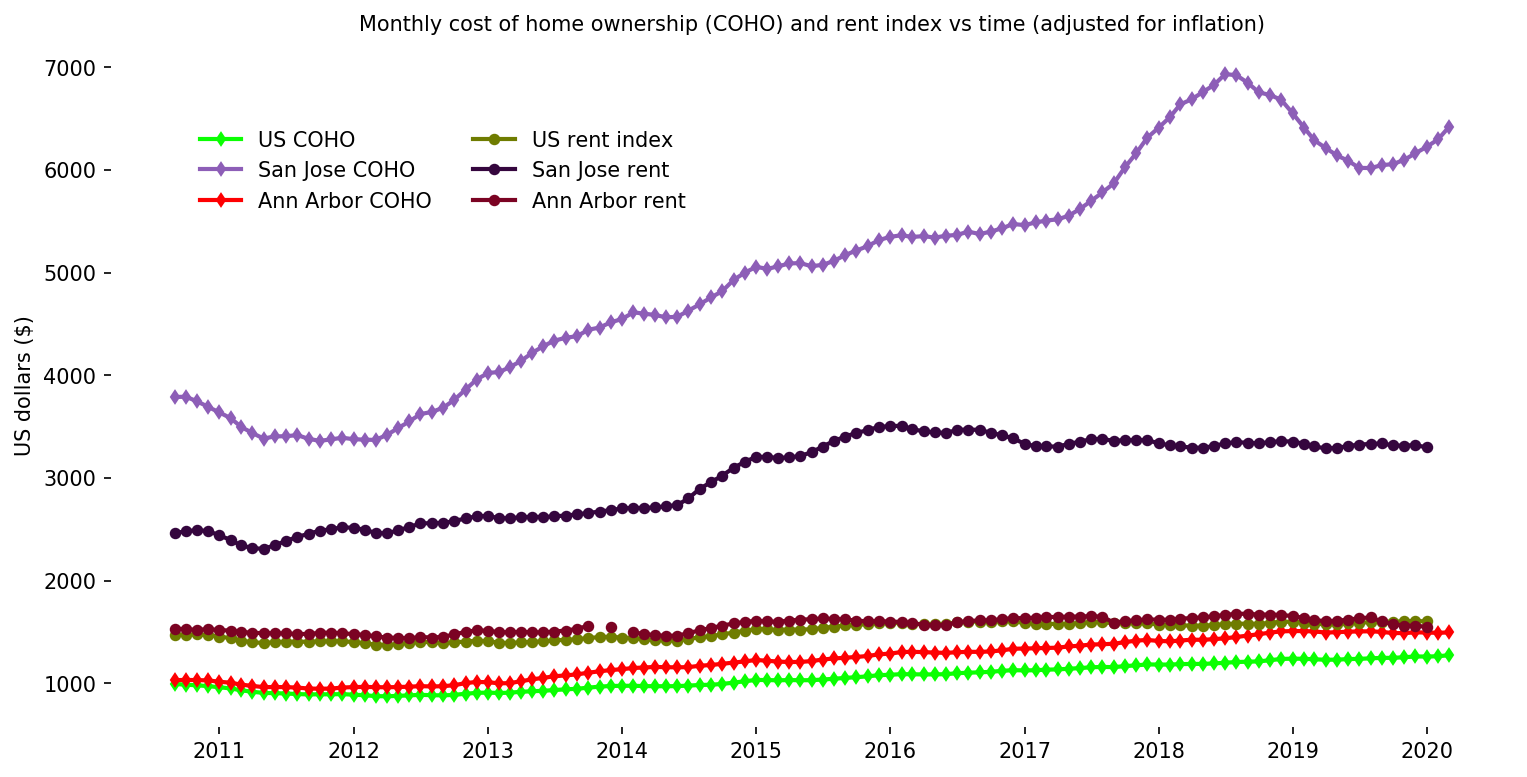

In [129]:
fig_3 = plt.figure(figsize=(10,5))

ax3 = fig_3.subplots()

ax3.set_prop_cycle(color=['xkcd:fluro green', 'xkcd:deep lavender', 'xkcd:fire engine red','xkcd:poop green', 'xkcd:dark purple', 'xkcd:wine red'])
ax3.plot(owner_costs.iloc[56:,:], 'd-', lw = 2, markersize=4)
ax3.plot(rent, 'o-', lw=2, markersize=4.5)

ax3.set_title("Monthly cost of home ownership (COHO) and rent index vs time (adjusted for inflation)",fontsize='smaller')
ax3.set_ylabel("US dollars ($)",fontsize='smaller')
ax3.legend(['US COHO','San Jose COHO','Ann Arbor COHO','US rent index','San Jose rent','Ann Arbor rent'],fontsize='smaller',frameon=False, loc="upper left", ncol=2, bbox_to_anchor=(0.05,0.9))
ax3.tick_params(axis='both', labelsize = 'small')

ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


fig_3.tight_layout(pad=0.05)
plt.savefig('home_owner_cost_vs_rent.png', dpi = 300)


plt.show()

## Home values compared to income
- Quick comparison of raw home values vs monthly income for the different regions
- An easier to digest visual is shown later, using cost of home ownership as monthly proxy for home value

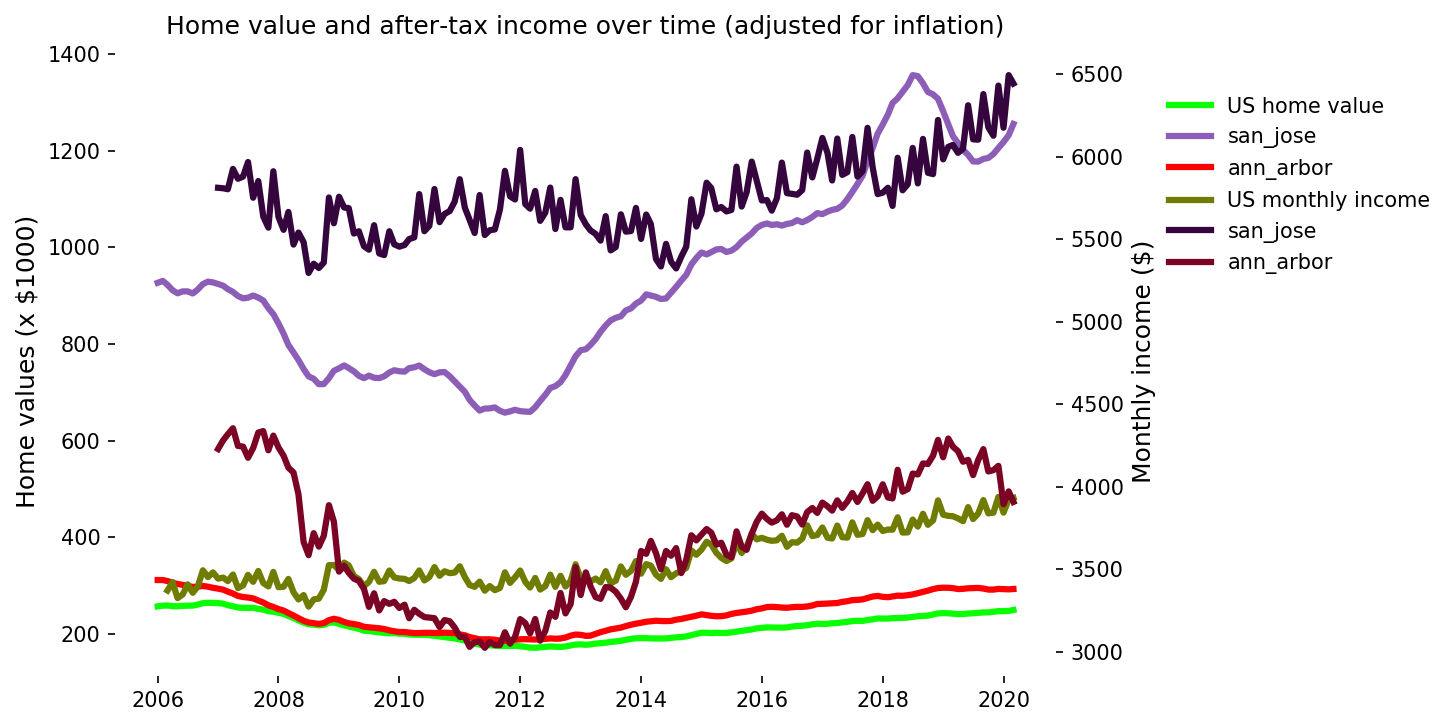

In [114]:
fig_3 = plt.figure(figsize=(10,5))

ax3 = fig_3.subplots()

ax3.set_prop_cycle(color=['xkcd:fluro green', 'xkcd:deep lavender', 'xkcd:fire engine red'])
ax3.plot(home_values, '-', lw = 3)
ax3.set_title("Home value and after-tax income over time (adjusted for inflation)",fontsize='medium')
ax3.set_ylabel("Home values (x $1000)")
ax3.legend(['US home value','san_jose','ann_arbor'],fontsize='small',frameon=False,loc="upper left",bbox_to_anchor=(1.1,0.95))
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.tick_params(axis='both', labelsize = 'small')

ax4 = ax3.twinx() # instantiate a second axes that shares the same x-axis
ax4.set_prop_cycle(color=['xkcd:poop green', 'xkcd:dark purple', 'xkcd:wine red']) #specify colors to plot
ax4.plot(income, '-', lw=3)
ax4.set_ylabel("Monthly income ($)")
ax4.legend(['US monthly income','san_jose','ann_arbor'],fontsize='small',frameon=False,loc="upper left",bbox_to_anchor=(1.1,0.8))
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.tick_params(axis='both', labelsize = 'small')

fig_3.tight_layout()
plt.show()

## Owner cost compared to income
- Using the following figure, we can come to some conclusions on the affordability of housing in the different geographic areas
- Naturally, home ownership is affordable if it costs less than one earns
- Again, Ann Arbor and the larger US average shows very similar trend, in this case an average wage-earner would spend about a 1/3 of their after-tax income on housing
- San Jose is also remarkably different in this respect, as the cost of ownership is over 1/2 of after-tax income for the average wage-earner
    - Additionally, a disturbing trend is seen in the past few years, as the cost of ownership has increased past the total after-tax income! 
    - We would expect that most homeowners purchasing homes in recent times must be substantially above the mean income or have >1 incomes per household 
- We can conclusively say that owning a home in Ann Arbor is more affordable than SJ, and is roughly the same as the broader US
- In fact, Ann Arbor's housing costs are low enough that a single person earning an "average" wage for the region is a sustainable model, notwithstanding other financial goals of the household
    - If there were two earners per household, a family could have ample resources to save, invest, or pursue hobbies!
    - We expect that, given an average wage, a homeowner in Ann Arbor probably has fewer financial worries than their couterpart in San Jose 
- Although San Jose has some nice things going for it too (weather, tech jobs?), one's dollar will get them further in Ann Arbor, which will give our fair Ann Arbor-ians something to think about as they are digging their cars out of the snow! 

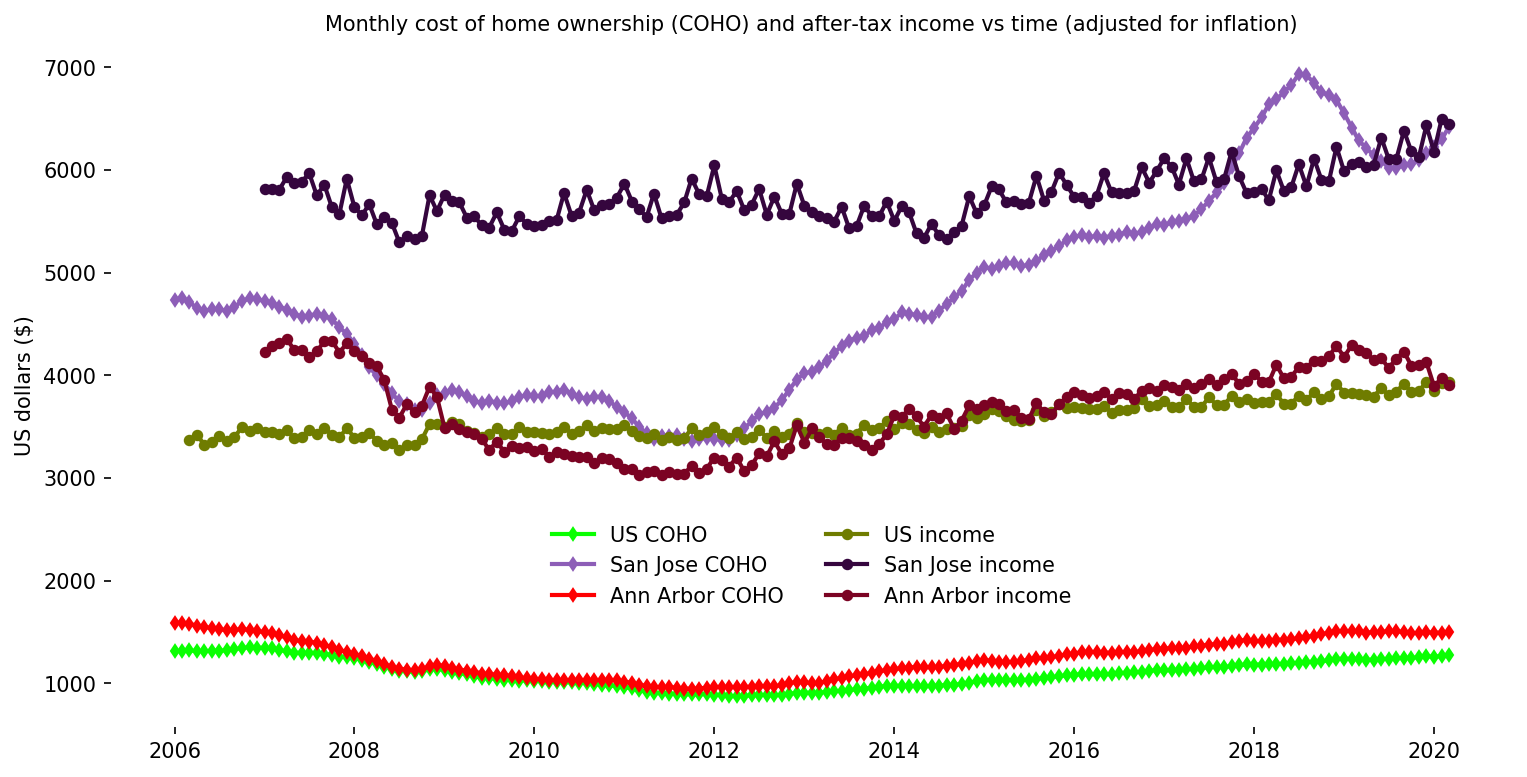

In [130]:
fig_4 = plt.figure(figsize=(10,5))

ax3 = fig_4.subplots()

ax3.set_prop_cycle(color=['xkcd:fluro green', 'xkcd:deep lavender', 'xkcd:fire engine red','xkcd:poop green', 'xkcd:dark purple', 'xkcd:wine red'])
ax3.plot(owner_costs, 'd-', lw = 2, markersize=4)
ax3.plot(income, 'o-', lw=2, markersize=4.5)

ax3.set_title("Monthly cost of home ownership (COHO) and after-tax income vs time (adjusted for inflation)",fontsize='smaller')
ax3.set_ylabel("US dollars ($)",fontsize='smaller')
ax3.legend(['US COHO','San Jose COHO','Ann Arbor COHO','US income','San Jose income','Ann Arbor income'],fontsize='smaller',frameon=False,loc="lower center", ncol=2, bbox_to_anchor=(0.5,0.15))
ax3.tick_params(axis='both', labelsize = 'small')

ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

fig_4.tight_layout(pad=0.05)
plt.savefig('home_owner_cost_vs_income.png', dpi = 300)

plt.show()